# Compare MendelImpute against Minimac4 and Beagle5 on simulated data

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using SparseArrays
# using Plots
# using ProfileView

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/biona001/.julia/packages/Revise/439di/src/Revise.jl:1108
┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273


# Simulate data

### Step 0. Install `msprime`

[msprime download Link](https://msprime.readthedocs.io/en/stable/installation.html).

Some people might need to activate conda environment via `conda config --set auto_activate_base True`. You can turn it off once simulation is done by executing `conda config --set auto_activate_base False`.


### Step 1. Simulate data in terminal

```
python3 msprime_script.py 4000 10000 2000000 2e-8 2e-8 2020 > ./compare6/haplo_ref.vcf
```

Arguments: 
+ Number of haplotypes = 4000
+ Effective population size = 10000 ([source](https://www.the-scientist.com/the-nutshell/ancient-humans-more-diverse-43556))
+ Sequence length = 10 million (same as Beagle 5's choice)
+ Rrecombination rate = 2e-8 (default)
+ mutation rate = 2e-8 (default)
+ seed = 2020

### Step 2: Convert simulated haplotypes to target genotype files

+ `haplo_ref.vcf`: simulated haplotype reference files
+ `target.vcf.gz`: complete genotype information
+ `target_masked.vcf.gz`: the same as `target.vcf.gz` except some entries are masked

In [38]:
# import haplotype reference panels
@time H = convert_ht(Float64, "./compare6/haplo_ref.vcf")
println(size(H))
people = 400
snps   = size(H, 2)

# simulate phased genotype matrices (each column is a haplotype)
@time X, hap_mosaics, hap_mosaic_range = simulate_phased_genotypes(copy(H'), people, 
    vcffilename="./compare6/target.vcf.gz");

# mask target vcf files
masks = [ifelse(rand() < 0.1, true, false) for i in 1:snps, j in 1:people]
masks = convert(BitArray{2}, masks)
@time mask_gt("./compare6/target.vcf.gz", masks, des="./compare6/target_masked.vcf.gz")

  3.477350 seconds (56.67 M allocations: 5.173 GiB, 18.58% gc time)
(4000, 14084)
  4.780958 seconds (43.00 M allocations: 2.698 GiB, 11.27% gc time)
  3.004597 seconds (17.20 M allocations: 1.754 GiB, 8.95% gc time)


In [39]:
hap_mosaics

400-element Array{Array{Tuple{Int64,Int64},1},1}:
 [(1646, 2919), (3668, 823), (3615, 1598)]                                       
 [(898, 3736), (3521, 1832)]                                                     
 [(1938, 3032), (3628, 2136), (470, 2318), (444, 2500)]                          
 [(3591, 2658), (839, 549)]                                                      
 [(2987, 2844), (3522, 1945), (1775, 680), (2564, 2892)]                         
 [(3754, 21), (1276, 1402)]                                                      
 [(220, 3514), (441, 3112), (2043, 3855), (1607, 303), (3918, 543)]              
 [(119, 3947), (3865, 154), (2989, 3581), (3873, 524)]                           
 [(982, 1220), (595, 2875), (3298, 335), (3568, 3307), (3932, 945), (403, 2043)] 
 [(491, 2326), (3580, 1706), (3536, 2406), (3990, 416), (2822, 1270)]            
 [(535, 3590), (2419, 1438)]                                                     
 [(2536, 1520), (3073, 627), (17, 5)]           

In [65]:
# impute
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 400
X = convert_ht(Float64, tgtfile, has_missing=true)
H = convert_ht(Float64, reffile)
X = copy(X')
H = copy(H')
@time hapset = compute_optimal_halotype_set_prephased(X, H, width=width);

 13.984851 seconds (18.70 M allocations: 553.243 MiB)


In [67]:
findall.(!iszero, hapset[1].strand1[1:10])
# findall.(!iszero, hapset[1].strand2[1:10])

10-element Array{Array{Int64,1},1}:
 [49, 58, 62, 71, 99, 108, 137, 154, 165, 241  …  3177, 3334, 3370, 3417, 3438, 3680, 3686, 3823, 3832, 3966]             
 [49, 58, 62, 99, 108, 137, 154, 165, 233, 241  …  3417, 3438, 3545, 3680, 3686, 3823, 3832, 3870, 3896, 3966]            
 [58, 88, 108, 139, 165, 229, 233, 241, 246, 272  …  3680, 3686, 3823, 3832, 3839, 3870, 3885, 3896, 3947, 3950]          
 [139, 233, 272, 574, 837, 843, 1018, 1190, 1432, 1492  …  1780, 2008, 2221, 2398, 2476, 2789, 2922, 3545, 3635, 3870]    
 [139]                                                                                                                    
 [272, 574, 1190, 1492, 1646, 2008, 3870]                                                                                 
 [1032, 1165, 1336, 1401, 1430, 1652, 1852, 2322, 3046, 3186, 3668, 3817, 3869, 3932]                                     
 [641, 822, 1032, 1165, 1251, 1336, 1401, 1430, 1524, 1596  …  3186, 3290, 3558, 3668, 3727, 3761, 3817

In [73]:
snps = size(X, 1)
windows = floor(Int, snps / width)
people = Int(size(X, 2) / 2)
found_right_haps = falses(2people, windows)

# divide each strand according to real mosaic range
window_ranges = collect(1:400:(snps-400))
for person in 1:people
    # loop over each window
    for (i, win_start) in enumerate(window_ranges)
        member = 1 #which mosaic current win belongs to
        for j in 1:length(hap_mosaic_range[person])
            if win_start in hap_mosaic_range[person][j]
                member = j
                break
            end
        end
        
        # match strand 1
        correct_hap = hap_mosaics[person][member]
        haps1 = findall(hs[person].strand1[i])
        found = false
        for hap in haps1
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person - 1, i] = found
        
        # match strand 2
        haps2 = findall(hs[person].strand2[i])
        found = false
        for hap in haps2
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person, i] = found
    end
end
sum(found_right_haps) / size(found_right_haps, 1) / size(found_right_haps, 2)

0.8484285714285714

In [70]:
# impute
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 400
@time hs, ph = phase(tgtfile, reffile, impute=true, 
                    outfile = outfile, width = width, prephased=true);

 42.538117 seconds (105.33 M allocations: 8.591 GiB, 2.94% gc time)


In [72]:
snps = size(X, 1)
windows = floor(Int, snps / width)
people = Int(size(X, 2) / 2)
found_right_haps = falses(2people, windows)

# divide each strand according to real mosaic range
window_ranges = collect(1:400:(snps-400))
for person in 1:people
    # loop over each window
    for (i, win_start) in enumerate(window_ranges)
        member = 1 #which mosaic current win belongs to
        for j in 1:length(hap_mosaic_range[person])
            if win_start in hap_mosaic_range[person][j]
                member = j
                break
            end
        end
        
        # match strand 1
        correct_hap = hap_mosaics[person][member]
        haps1 = findall(hapset[person].strand1[i])
        found = false
        for hap in haps1
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person - 1, i] = found
        
        # match strand 2
        haps2 = findall(hapset[person].strand2[i])
        found = false
        for hap in haps2
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person, i] = found
    end
end
sum(found_right_haps) / size(found_right_haps, 1) / size(found_right_haps, 2)

0.9042857142857142

In [74]:
# impute
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 400
X = convert_gt(Float64, tgtfile)
H = convert_ht(Float64, reffile)
X = copy(X')
H = copy(H')
@time hapset = compute_optimal_halotype_set(X, H, width=width);

  2.667387 seconds (461.13 k allocations: 88.308 MiB, 3.80% gc time)


In [75]:
snps = size(X, 1)
windows = floor(Int, snps / width)
people = Int(size(X, 2) / 2)
found_right_haps = falses(2people, windows)

# divide each strand according to real mosaic range
window_ranges = collect(1:400:(snps-400))
for person in 1:people
    # loop over each window
    for (i, win_start) in enumerate(window_ranges)
        member = 1 #which mosaic current win belongs to
        for j in 1:length(hap_mosaic_range[person])
            if win_start in hap_mosaic_range[person][j]
                member = j
                break
            end
        end
        
        # match strand 1
        correct_hap = hap_mosaics[person][member]
        haps1 = findall(hapset[person].strand1[i])
        found = false
        for hap in haps1
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person - 1, i] = found
        
        # match strand 2
        haps2 = findall(hapset[person].strand2[i])
        found = false
        for hap in haps2
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person, i] = found
    end
end
sum(found_right_haps) / size(found_right_haps, 1) / size(found_right_haps, 2)

0.9195714285714286

In [77]:
# impute
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 400
@time hs, ph = phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

 25.044931 seconds (98.31 M allocations: 9.063 GiB, 5.19% gc time)


In [78]:
snps = size(X, 1)
windows = floor(Int, snps / width)
people = Int(size(X, 2) / 2)
found_right_haps = falses(2people, windows)

# divide each strand according to real mosaic range
window_ranges = collect(1:400:(snps-400))
for person in 1:people
    # loop over each window
    for (i, win_start) in enumerate(window_ranges)
        member = 1 #which mosaic current win belongs to
        for j in 1:length(hap_mosaic_range[person])
            if win_start in hap_mosaic_range[person][j]
                member = j
                break
            end
        end
        
        # match strand 1
        correct_hap = hap_mosaics[person][member]
        haps1 = findall(hs[person].strand1[i])
        found = false
        for hap in haps1
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person - 1, i] = found
        
        # match strand 2
        haps2 = findall(hs[person].strand2[i])
        found = false
        for hap in haps2
            if hap in correct_hap
                found = true
            end
        end
        found_right_haps[2person, i] = found
    end
end
sum(found_right_haps) / size(found_right_haps, 1) / size(found_right_haps, 2)

0.8675714285714285

# BitVector intersection win-by-win error

### using prephase information

In [43]:
# impute
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 400
@time hs, ph = phase(tgtfile, reffile, impute=true, 
                    outfile = outfile, width = width, prephased=true);

 40.443406 seconds (105.35 M allocations: 8.591 GiB, 3.17% gc time)


In [51]:
# import imputed result and compare with true
X_mendel_ht   = convert_ht(Float32, outfile, as_minorallele=false)
X_complete_ht = convert_ht(Float32, "./compare6/target.vcf.gz"; as_minorallele=false)
haps, snps = size(X_mendel)
error_rate = sum(X_mendel_ht .!= X_complete_ht) / haps / snps
println("error rate for $haps haplotypes = $error_rate")
println("")
println("")

for person in 1:people
    try 
        # error rate
        h1_error = sum(X_complete[2person - 1, :] .!= X_mendel[2person - 1, :]) / snps
        h2_error = sum(X_complete[2person, :] .!= X_mendel[2person, :]) / snps
        println("person $person hap 1 error = $h1_error")
        println("person $person hap 2 error = $h2_error")

        # correct haplotypes
        for (i, pair) in enumerate(hap_mosaics[person])
            println("snps ", hap_mosaic_range[person][i], " has correct hap 1 = ", pair[1])
            println("snps ", hap_mosaic_range[person][i], " has correct hap 2 = ", pair[2])
        end
        println("")
        
        # predicted haplotypes
        print("strand 1 predicted haplotypes = ")
        for i in 1:length(ph[person].strand1.haplotypelabel)
            print(ph[person].strand1.haplotypelabel[i], ", ")
        end
        println("")
        print("strand 2 predicted haplotypes = ")
        for i in 1:length(ph[person].strand2.haplotypelabel)
            print(ph[person].strand2.haplotypelabel[i], ", ")
        end
        println("")
        
        # correct & predicted haplotypes ranges
        print("strand 1 predicted hap range: ")
        [print(myrange, ", ") for myrange in ph[person].strand1.start]
        println("")
        print("strand 2 predicted hap ranges: ")
        [print(myrange, ", ") for myrange in ph[person].strand2.start]
        println("")
        println("")
    catch e
        println("")
        println("")
        continue
    end
end

error rate for 400 haplotypes = 0.0017335274069866515


person 1 hap 1 error = 0.00028401022436807724
person 1 hap 2 error = 0.00028401022436807724
snps 1:6292 has correct hap 1 = 3250
snps 1:6292 has correct hap 2 = 1641
snps 6293:8787 has correct hap 1 = 2066
snps 6293:8787 has correct hap 2 = 3190
snps 8788:9570 has correct hap 1 = 3827
snps 8788:9570 has correct hap 2 = 2331
snps 9571:10858 has correct hap 1 = 2626
snps 9571:10858 has correct hap 2 = 3594
snps 10859:14084 has correct hap 1 = 2082
snps 10859:14084 has correct hap 2 = 330

strand 1 predicted haplotypes = 3250, 188, 2066, 12, 2966, 46, 733, 
strand 2 predicted haplotypes = 1352, 2, 3190, 664, 138, 107, 157, 330, 
strand 1 predicted hap range: 1, 6349, 6265, 8787, 9599, 9570, 10852, 
strand 2 predicted hap ranges: 1, 6278, 6595, 8001, 8855, 9944, 10544, 10845, 

person 2 hap 1 error = 0.00035501278046009654
person 2 hap 2 error = 0.00014200511218403862
snps 1:2362 has correct hap 1 = 900
snps 1:2362 has correct hap 2 =

### no prephase information

In [5]:
# impute: old bitvector method's error 
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 800
@time hs, ph = phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

# import imputed result and compare with true
X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
X_complete  = convert_gt(Float32, "./compare6/target.vcf.gz"; as_minorallele=false)
n, p = size(X_mendel)
error_rate = sum(X_mendel .!= X_complete) / n / p

 67.438803 seconds (97.93 M allocations: 9.085 GiB, 1.42% gc time)


0.00023803606929849474

In [3]:
# impute 
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 400
@time hs, ph = phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

# import imputed result and compare with true
X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
X_complete  = convert_gt(Float32, "./compare6/target.vcf.gz"; as_minorallele=false)
n, p = size(X_mendel)
error_rate = sum(X_mendel .!= X_complete) / n / p

 24.239690 seconds (98.31 M allocations: 9.063 GiB, 4.88% gc time)


0.0001576256745242829

In [37]:
# import imputed result and compare with true
error_rate = sum(X_complete .!= X_mendel) / people / snps
println("error rate for first $people people = $error_rate")
println("")
println("")

y_backtrack_count = 0
n_backtrack_count = 0
y_backtrack_error = 0.0
n_backtrack_error = 0.0
for person in 1:people
    try 
        # error rate
        error_rate = sum(X_complete[person, :] .!= X_mendel[person, :]) / snps
        println("person $person error = $error_rate")
        
        # check backtracking
        if all(diff(ph[person].strand1.start) .>= 0) && all(diff(ph[person].strand2.start) .>= 0)
            n_backtrack_count += 1
            n_backtrack_error += error_rate
        else
            y_backtrack_count += 1
            y_backtrack_error += error_rate
        end
        
        # correct and predicted haplotype pairs
        print("correct haplotypes  : ")
        [print((minimum(pair), maximum(pair)), ", ") for pair in hap_mosaics[person]]
        println("")
        print("predicted haplotypes: ")    
        for i in 1:length(ph[person].strand1.haplotypelabel)
            pair = (ph[person].strand1.haplotypelabel[i], ph[person].strand2.haplotypelabel[i])
            print((minimum(pair), maximum(pair)), ", ")
        end
        println("")

        # correct & predicted haplotypes ranges
        print("correct haplotype ranges: ")
        [print(haprange, ", ") for haprange in hap_mosaic_range[person]]
        println("")
        print("predicted haplotype ranges strand 1: ")
        [print(myrange, ", ") for myrange in ph[person].strand1.start]
        println("")
        print("predicted haplotype ranges strand 2: ")
        [print(myrange, ", ") for myrange in ph[person].strand2.start]
        println("")
        println("")
    catch e
        println("")
        println("")
        continue
    end
end

error rate for first 400 people = 0.00016827605793808578


person 1 error = 0.00028401022436807724
correct haplotypes  : (1641, 3250), (2066, 3190), (2331, 3827), (2626, 3594), (330, 2082), 
predicted haplotypes: (1352, 3250), (2066, 3190), (664, 838), (12, 2966), (46, 138), (107, 1691), (330, 733), 
correct haplotype ranges: 1:6292, 6293:8787, 8788:9570, 9571:10858, 10859:14084, 
predicted haplotype ranges strand 1: 1, 6286, 8732, 8662, 8801, 9570, 10850, 
predicted haplotype ranges strand 2: 1, 6280, 8958, 8801, 9570, 10858, 10845, 

person 2 error = 0.00028401022436807724
correct haplotypes  : (900, 3100), (909, 3247), (2850, 3209), (2931, 3986), (36, 1176), 
predicted haplotypes: (482, 585), (1, 3021), (95, 909), (19, 784), (65, 1161), (101, 165), (868, 1908), 
correct haplotype ranges: 1:2362, 2363:3843, 3844:10007, 10008:12244, 12245:14084, 
predicted haplotype ranges strand 1: 1, 2340, 2338, 3841, 4801, 9982, 12238, 
predicted haplotype ranges strand 2: 1, 2368, 2345, 3861, 3821

In [40]:
@show y_backtrack_count
@show n_backtrack_count
@show y_backtrack_error / y_backtrack_count
@show n_backtrack_error / n_backtrack_count

y_backtrack_count = 309
n_backtrack_count = 91
y_backtrack_error / y_backtrack_count = 0.00017945953497691618
n_backtrack_error / n_backtrack_count = 0.00013030139414689254


0.00013030139414689254

# Dynamic programming

In [4]:
# impute
tgtfile = "./compare6/target_masked.vcf.gz"
reffile = "./compare6/haplo_ref.vcf"
outfile = "./compare6/imputed_target.vcf.gz"
width   = 800
@time hs, ph = phase(tgtfile, reffile, impute=true, outfile = outfile, width = width);

# import imputed result and compare with true
X_mendel = convert_gt(Float32, outfile, as_minorallele=false)
X_complete  = convert_gt(Float32, "./compare6/target.vcf.gz"; as_minorallele=false)
n, p = size(X_mendel)
error_rate = sum(X_mendel .!= X_complete) / n / p

208.985797 seconds (1.73 G allocations: 82.192 GiB, 5.56% gc time)


0.00023839108207895484

# Beagle 5 error

In [17]:
# run beagle 5 and import imputed data 
run(`java -jar beagle.28Sep18.793.jar gt=./compare6/target_masked.vcf.gz ref=./compare6/haplo_ref.vcf out=./compare6/beagle.result`)

# beagle 5 error rate
X_beagle = convert_gt(Float32, "./compare6/beagle.result.vcf.gz", as_minorallele=false)
error_rate = sum(X_beagle .!= X_complete) / n / p

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 10:58 PM PDT on 08 Mar 2020

Command line: java -Xmx3641m -jar beagle.28Sep18.793.jar
  gt=./compare6/target_masked.vcf.gz
  ref=./compare6/haplo_ref.vcf
  out=./compare6/beagle.result

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,000
Study samples:             400

Window 1 (1:26-4999996)
Reference markers:      35,232
Study markers:              29

Burnin  iteration 1:           0 seconds
Burnin  iteration 2:           0 seconds
Burnin  iteration 3:           0 seconds
Burnin  iteration 4:           0 seconds
Burnin  iteration 5:           0 seconds
Burnin  iteration 6:           0 seconds

Phasing iteration 1:           0 seconds
Phasing iteration 2:           0 seconds
Phasing iteration 3:           0 seconds
Phasing iteration 4:           0 seconds
Phasing iteration 5:           0 seconds
Ph

ErrorException: GeneticVariation.VCF.Reader file format error on line 11 ~>"�;IMP\t"

# Minimac4 error

Need to first convert reference vcf file to m3vcf using minimac3 (on Hoffman)

```Julia
minimac3 = "/u/home/b/biona001/haplotype_comparisons/minimac3/Minimac3/bin/Minimac3"
@time run(`$minimac3 --refHaps haplo_ref.vcf.gz --processReference --prefix haplo_ref`)
```

In [17]:
# run minimac 4
minimac4 = "/Users/biona001/Benjamin_Folder/UCLA/research/softwares/Minimac4/build/minimac4"
run(`$minimac4 --refHaps haplo_ref.m3vcf.gz --haps target_masked.vcf.gz --prefix minimac4.result`)
    
X_minimac = convert_gt(Float32, "minimac4.result.dose.vcf.gz", as_minorallele=false)
error_rate = sum(X_minimac .!= X_complete) / n / p



 -------------------------------------------------------------------------------- 
          Minimac4 - Fast Imputation Based on State Space Reduction HMM
 --------------------------------------------------------------------------------
           (c) 2014 - Sayantan Das, Christian Fuchsberger, David Hinds
                             Mary Kate Wing, Goncalo Abecasis 

 Version: 1.0.2;
 Built: Mon Sep 30 11:52:22 PDT 2019 by biona001

 Command Line Options: 
       Reference Haplotypes : --refHaps [haplo_ref.m3vcf.gz], --passOnly,
                              --rsid, --referenceEstimates [ON],
                              --mapFile [docs/geneticMapFile.b38.map.txt.gz]
          Target Haplotypes : --haps [target_masked.vcf.gz]
          Output Parameters : --prefix [minimac4.result], --estimate,
                              --nobgzip, --vcfBuffer [200], --format [GT,DS],
                              --allTypedSites, --meta, --memUsage
        Chunking Parameters : --ChunkLengthMb

0.00018399866284090594

# Visualize error distribution

Minimac4 does not preserve non-missing data! 

In [18]:
# did mendel/beagle/minimac preserve non-missing data?
missing_idx = ismissing.(Xm_original)
@show sum(X_complete[.!missing_idx] .!= X_mendel[.!missing_idx])
@show sum(X_complete[.!missing_idx] .!= X_beagle[.!missing_idx])
@show sum(X_complete[.!missing_idx] .!= X_minimac[.!missing_idx])

sum(X_complete[.!(missing_idx)] .!= X_mendel[.!(missing_idx)]) = 0
sum(X_complete[.!(missing_idx)] .!= X_beagle[.!(missing_idx)]) = 0
sum(X_complete[.!(missing_idx)] .!= X_minimac[.!(missing_idx)]) = 5513


5513

In [19]:
# total number of wrong values
@show sum(X_complete .!= X_mendel)
@show sum(X_complete .!= X_beagle)
@show sum(X_complete .!= X_minimac)

sum(X_complete .!= X_mendel) = 4803
sum(X_complete .!= X_beagle) = 801
sum(X_complete .!= X_minimac) = 6605


6605

In [20]:
# Mendel 
Random.seed!(2019)
X_complete  = convert_gt(Float32, "target.vcf.gz"; as_minorallele=false)
X_mendel = convert_gt(Float32, "imputed_target.vcf.gz", as_minorallele=false)
mendel_disagreeing_entries = randn(size(X_complete)) .* sparse(X_complete .!= X_mendel)

# Beagle 5.0
X_beagle = convert_gt(Float32, "beagle.result.vcf.gz", as_minorallele=false)
beagle_disagreeing_entries = randn(size(X_complete)) .* sparse(X_complete .!= X_beagle)

# Minimac 4
X_minimac = convert_gt(Float32, "minimac4.result.dose.vcf.gz", as_minorallele=false)
minimac_disagreeing_entries = randn(size(X_complete)) .* sparse(X_complete .!= X_minimac);

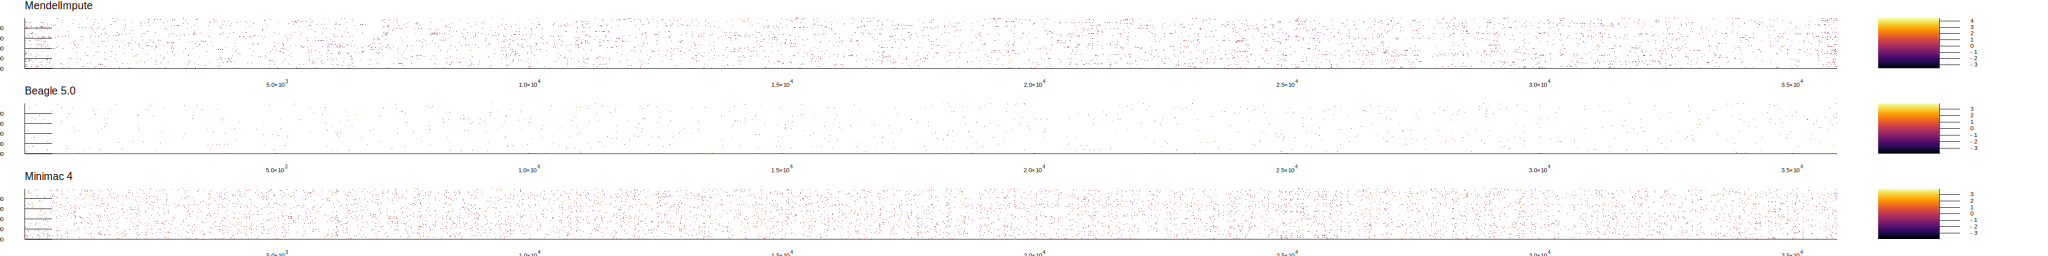

In [21]:
A = Plots.spy(mendel_disagreeing_entries, size=(4000,500), title="MendelImpute", title_location=:left)
B = Plots.spy(beagle_disagreeing_entries, size=(4000,500), title="Beagle 5.0", title_location=:left)
C = Plots.spy(minimac_disagreeing_entries, size=(4000,500), title="Minimac 4", title_location=:left)
plot(A, B, C, layout = (3, 1))

In [36]:
@show count(!iszero, mendel_disagreeing_entries[:, 1:400])
@show count(!iszero, mendel_disagreeing_entries[:, 401:800])
@show count(!iszero, mendel_disagreeing_entries[:, 801:1200])
@show count(!iszero, mendel_disagreeing_entries[:, 1201:1600])
@show count(!iszero, mendel_disagreeing_entries[:, 1601:2000])
@show count(!iszero, mendel_disagreeing_entries[:, 2001:2400])
# width = 400
# for i in 1:Int(ceil(size(X_complete, 2) / width)) - 1
#     println(count(!iszero, mendel_disagreeing_entries[:, (1 + 400(i - 1)):400i]))
# end

count(!iszero, mendel_disagreeing_entries[:, 1:400]) = 348
count(!iszero, mendel_disagreeing_entries[:, 401:800]) = 95
count(!iszero, mendel_disagreeing_entries[:, 801:1200]) = 64
count(!iszero, mendel_disagreeing_entries[:, 1201:1600]) = 87
count(!iszero, mendel_disagreeing_entries[:, 1601:2000]) = 70
count(!iszero, mendel_disagreeing_entries[:, 2001:2400]) = 67


67